In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy import stats
from sklearn.decomposition import PCA


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


**A.** (code) Download and import the Santander dataset. The labels of the test data are not publicly available, so create your own test set by randomly choosing half of the instances in the
original training set.

In [2]:
#Load the Data
df = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
# Split in train and test by randomly choosing half of the istances in the training set 
df, df_test = train_test_split(df, test_size=0.5, random_state=42)
X_train = df.dropna().iloc[:, 2:].values
y_train = df.dropna().iloc[:, 1].values
X_test = df_test.dropna().iloc[:, 2:].values
y_test = df_test.dropna().iloc[:, 1].values

**B.** (text) Comment on the distribution of class labels and the dimensionality of the input and how
these may affect the analysis.

In [4]:
print('Number of training samples: %s' % str(len(X_train)))
print('Number of testing samples: %s' % str(len(X_test)))
print('Shape input train: %s' % str(X_train.shape))
print('Shape input test: %s' % str(X_test.shape))

Number of training samples: 100000
Number of testing samples: 100000
Shape input train: (100000, 200)
Shape input test: (100000, 200)


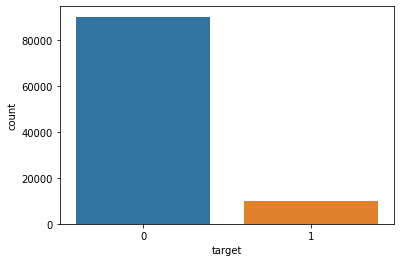

In [5]:
sns.countplot(x=df['target']);

# Add comment

**A.** (code) Implement Bayesian linear regression

In [6]:
def build_features(x, K):
        X = np.ones(x.shape)
        for k in range(1, K + 1):
            X = np.column_stack((X, x ** k))
        return X

In [7]:
def bayesian_linear_regression(x, y, xt, K, sn2, sw2):
        
    def compute_posterior(X, y, sw2, sn2):
        _, cov_size = X.shape

        S_inv = 1/sw2 * np.eye(cov_size)
    
        Sigma_inv = 1/sn2 * X.T @ X + S_inv
        Sigma = np.linalg.inv(Sigma_inv)
        w_posterior_cov = Sigma
        w_posterior_mean = (1/sn2) * Sigma @ X.T @ y
    
        return (w_posterior_mean,  w_posterior_cov)
    

    def compute_predictive(Xt, w_mean, w_cov, sn2):
        def _compute_predictive_single_point(xt_i, w_mean, w_cov, sn2):
            yt_i_mean = np.dot(xt_i.T, w_mean)
            yt_i_var = sn2 + np.dot(np.dot(xt_i.T, w_cov), xt_i)
            return yt_i_mean, yt_i_var

        yt_mean, yt_var = np.zeros(len(Xt)), np.zeros(len(Xt))
        for i, xt_i in enumerate(Xt):  # Loop on all the points
            yt_mean[i], yt_var[i] = _compute_predictive_single_point(
                xt_i, w_mean, w_cov, sn2
            )

        return yt_mean, yt_var
    
    def sample(Xt, w_mean, w_cov, sn2, N):
        def _sample_single(Xt, w_mean, w_cov, sn2):
            w_posterior = np.random.multivariate_normal(w_mean, w_cov)
            #noise = np.random.normal(0, sn2)
            f = np.dot(Xt, w_posterior) #+ noise
            return f 

        samples = np.zeros((N, len(Xt)))
        for i in range(N):
            samples[i] = _sample_single(Xt, w_mean, w_cov, sn2)
        return samples


    X = build_features(x, K) 
    Xt = build_features(xt, K)  
    w_posterior_mean, w_posterior_cov = compute_posterior(X, y, sw2, sn2)
    y_mean, y_var =  compute_predictive(Xt, w_posterior_mean, w_posterior_cov, sn2)
    samples = sample(Xt, w_posterior_mean, w_posterior_cov, sn2, N=30)
    return y_mean, y_var, samples

In [8]:
sn2 = 1
sw2 = 1

In [9]:
def lognormal(x, mu, var):
    return - np.log(np.sqrt(2 * np.pi * var)) - (x - mu) ** 2 / (2 * var)

def gaussian_loglik(y, y_tilde, sn2):
    return np.sum(lognormal(y, y_tilde, sn2))

In [10]:
def evaluate_likelihood(x, y, K, sn2, sw2):
    y_mean, y_var, _ = bayesian_linear_regression(x, y, x, K, sn2, sw2)
    
    ll = gaussian_loglik(y, y_mean, y_var)
    return ll

In [11]:
def marginal_likelihood(X, y, sw2, sn2):
    mu_zero = np.zeros(X.shape[1])
    cov_zero =  sw2 * np.eye(X.shape[1])
    mean = np.dot(X, mu_zero)
    cov =  sn2 * np.eye(X.shape[0]) + np.dot(np.dot(X, cov_zero), X.T)
    logpdf = scipy.stats.multivariate_normal.logpdf(y, mean,cov)
    return  logpdf

def evaluate_marginal_likelihood(x, y, K, sn2, sw2):
    X = build_features(x, K)
    return  marginal_likelihood(X, y, sw2, sn2)

**B.**(text) Describe any pre-processing that you suggest for this data

## Scale the data

In [12]:
Xmean, Xstd = X_train.mean(0), X_train.std(0)
X_train = (X_train - Xmean) / Xstd
X_test = (X_test - Xmean) / Xstd

## Dimensionality Reduction

In [13]:
sums = []
for i in range(1, 200):
    pca = PCA(n_components=i, svd_solver='full')
    pca.fit_transform(X_train)
    sums.append(np.sum(pca.explained_variance_ratio_))

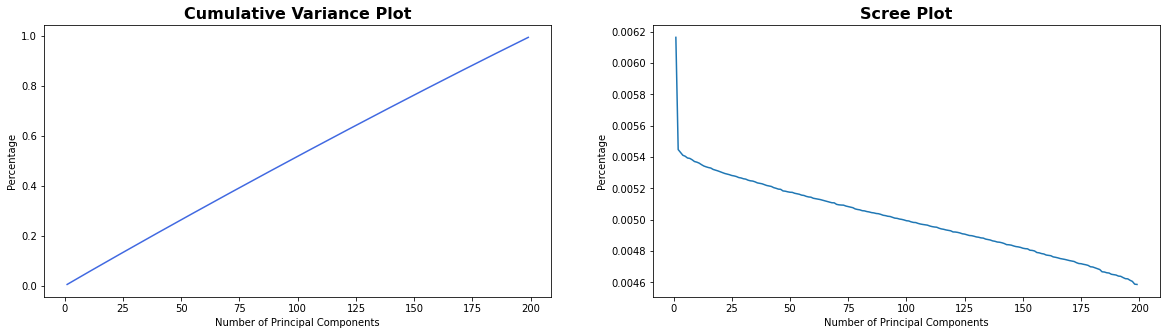

In [14]:
# PLOT THE RESULT
plt.figure(figsize=(20,5))
ticks = np.arange(1, len(sums)+1)
plt.subplot(1,2,1)
plt.title("Cumulative Variance Plot", weight="semibold", fontsize=16)
plt.xlabel("Number of Principal Components")
plt.ylabel("Percentage")
plt.plot(ticks, sums, color="royalblue")
plt.subplot(1,2,2)
plt.title("Scree Plot", weight="semibold", fontsize=16)
plt.plot(ticks, pca.explained_variance_ratio_)
plt.xlabel("Number of Principal Components")
plt.ylabel("Percentage")
plt.show()

In [15]:
print(sums[175])

0.8884061774929619


In [16]:
pca = PCA(n_components=175, svd_solver='full')
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## Unbalanced Class